In [94]:
import matplotlib.pyplot as mp

import cartopy
import numpy
import xarray
import pandas
import netCDF4
import scipy.stats
import cmocean
import glob
import re
import datetime

mp.rcParams.update({'mathtext.default': 'regular'})

In [26]:
!ls /beegfs/DATA/pritchard/blangenb/APHRODITE_DATA/APHRO_MA_TAVE_025deg_V1204R1.1961-2007.nc/

APHRO_MA_TAVE_025deg_V1204R1.1961.nc  APHRO_MA_TAVE_025deg_V1204R1.1985.nc
APHRO_MA_TAVE_025deg_V1204R1.1962.nc  APHRO_MA_TAVE_025deg_V1204R1.1986.nc
APHRO_MA_TAVE_025deg_V1204R1.1963.nc  APHRO_MA_TAVE_025deg_V1204R1.1987.nc
APHRO_MA_TAVE_025deg_V1204R1.1964.nc  APHRO_MA_TAVE_025deg_V1204R1.1988.nc
APHRO_MA_TAVE_025deg_V1204R1.1965.nc  APHRO_MA_TAVE_025deg_V1204R1.1989.nc
APHRO_MA_TAVE_025deg_V1204R1.1966.nc  APHRO_MA_TAVE_025deg_V1204R1.1990.nc
APHRO_MA_TAVE_025deg_V1204R1.1967.nc  APHRO_MA_TAVE_025deg_V1204R1.1991.nc
APHRO_MA_TAVE_025deg_V1204R1.1968.nc  APHRO_MA_TAVE_025deg_V1204R1.1992.nc
APHRO_MA_TAVE_025deg_V1204R1.1969.nc  APHRO_MA_TAVE_025deg_V1204R1.1993.nc
APHRO_MA_TAVE_025deg_V1204R1.1970.nc  APHRO_MA_TAVE_025deg_V1204R1.1994.nc
APHRO_MA_TAVE_025deg_V1204R1.1971.nc  APHRO_MA_TAVE_025deg_V1204R1.1995.nc
APHRO_MA_TAVE_025deg_V1204R1.1972.nc  APHRO_MA_TAVE_025deg_V1204R1.1996.nc
APHRO_MA_TAVE_025deg_V1204R1.1973.nc  APHRO_MA_TAVE_025deg_V1204R1.1997.nc
APHRO_MA_TAVE_025deg_V120

In [27]:
root_dir = '/beegfs/DATA/pritchard/blangenb/APHRODITE_DATA/APHRO_MA_TAVE_025deg_V1204R1.1961-2007.nc/'

In [46]:
file_list = sorted(glob.glob(root_dir+'*'))

In [47]:
reg_exp = re.compile('.*(198|199|200)(\w)(.nc)$')
file_list = numpy.array([filename for filename in file_list if re.match(reg_exp, filename)])

In [49]:
aphro_mfds = xarray.open_mfdataset(file_list)

In [52]:
aphro_mfds

<xarray.Dataset>
Dimensions:    (latitude: 280, longitude: 360, time: 9862)
Coordinates:
  * longitude  (longitude) float64 60.12 60.38 60.62 60.88 61.12 61.38 61.62 ...
  * latitude   (latitude) float64 -14.88 -14.62 -14.38 -14.12 -13.88 -13.62 ...
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 1980-01-03 ...
Data variables:
    tave       (time, latitude, longitude) float32 dask.array<shape=(9862, 280, 360), chunksize=(366, 280, 360)>
    rstn       (time, latitude, longitude) float32 dask.array<shape=(9862, 280, 360), chunksize=(366, 280, 360)>
Attributes:
    Conventions:  COARDS
    calendar:     standard
    comments:     APHRO_MA V1204R1 daily precipitation with 0.25deg grids
    history:      Created by APHRODITE project team 28- 3月-2013

In [108]:
tave_data_subset = aphro_mfds['tave'].sel(time=slice('1990-1-1','2005-12-31')).values
tave_time_subset = aphro_mfds['time'].sel(time=slice('1990-1-1','2005-12-31')).values
# (time=slice(datetime.datetime(1990,1,1),datetime.datetime(2005,12,31))).values
lon = aphro_mfds['longitude'].values
lat = aphro_mfds['latitude'].values

In [136]:
tave_time_subset_pydatetime = pandas.Series(tave_time_subset).dt.to_pydatetime()
tave_time_subset_date2num = netCDF4.date2num(tave_time_subset_pydatetime, units='days since 1990-1-1', calendar='standard')

In [159]:
tave_trend = numpy.zeros((lat.size,lon.size))*numpy.nan
tave_pvals = numpy.zeros((lat.size,lon.size))*numpy.nan

for i in range(lat.size):
    for j in range(lon.size):
        x = tave_time_subset_date2num[~numpy.isnan(tave_data_subset[:,i,j])]
        y = tave_data_subset[~numpy.isnan(tave_data_subset[:,i,j]),i,j]
        # if all NaNs, go to the next gridpoint
        if x.size==0:
            continue
        tave_trend[i,j], blah, blah, tave_pvals[i,j], blah = \
        scipy.stats.linregress(x,y)

In [90]:
tave_data_timemean = numpy.nanmean(tave_data, axis=0)

/export/home/blangenb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


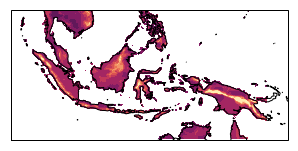

In [138]:
map_proj = cartopy.crs.PlateCarree()
data_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(4.25,2.5))
ax = fig.add_subplot(111, projection=map_proj)

levels = numpy.arange(20,30.1,1)
ax.contourf(lon,lat,tave_data_timemean,\
            levels=levels,\
            cmap=cmocean.cm.matter, \
            extend='both')

ax.set_extent([90,155,-13,13])
ax.coastlines(resolution='50m')

fig.tight_layout()

plot trends

In [140]:
lon_pcolormesh = numpy.zeros(lon.size+2)
lon_pcolormesh[1:-1] = lon
lon_pcolormesh[0] = lon[0]-numpy.diff(lon)[0]
lon_pcolormesh[-1] = lon[-1]+numpy.diff(lon)[-1]

lon_mid = lon_pcolormesh[:-1]+0.5*(numpy.diff(lon_pcolormesh))

lat_pcolormesh = numpy.zeros(lat.size+2)
lat_pcolormesh[1:-1] = lat
lat_pcolormesh[0] = lat[0]-numpy.diff(lat)[0]
lat_pcolormesh[-1] = lat[-1]+numpy.diff(lat)[-1]

lat_mid = lat_pcolormesh[:-1]+0.5*(numpy.diff(lat_pcolormesh))

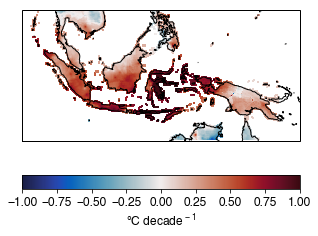

In [183]:
fontsize = 12

map_proj = cartopy.crs.PlateCarree()
data_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(4.25,3.5))
ax = fig.add_subplot(111, projection=map_proj)

trend_plot = ax.pcolormesh(lon_mid,lat_mid,tave_trend*365.25*10.,\
                           cmap=cmocean.cm.balance, vmin=-1.,vmax=1.)

ax.set_extent([90,155,-13,13])
ax.coastlines(resolution='50m')

fig.tight_layout()

cbar = mp.colorbar(trend_plot, orientation='horizontal')
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label('$\degree$C decade$^{\,-1}$', fontsize=fontsize)